In [1]:
import pandas as pd
import seaborn as sns
import igraph
import numpy as np
import matplotlib.pyplot as plt
from genderize import Genderize
from IPython.display import Image
import json
from urllib.request import urlopen
from urllib.parse import quote

%matplotlib inline

# Classes and functions for simulations

In [528]:
class Author:
    def __init__(self, network_bias:float, beta:float, meet_bias:float, walk_bias:float, gender='F'):
        '''
        Inputs:
            gender          string, 'W' or 'M'
            beta            a scalar float. Determines how this author learns from others
            meet_bias       a scalar float. Determines how similar a strangers network has to 
                            be to meet with them
            network_bias    a scalar float. Determines how much their estimated social notwork 
                            is biased towards people with the same gender. 0 men will be chosen 
                            whenever possible, and 1 indicates women will be hcosen whenever possible
            walk_bias       a scalar floar. Determines how much people will bias themselves towards 
                            women in their citations
        '''
        gender = gender.upper()
        if (gender != 'W') & (gender != 'M'):
            raise Exception('Gender should be W or M')
            
        if type(beta) != float:
            raise Exception('Beta should be a float')
            
        if type(meet_bias) != float:
            raise Exception('Meeting bias should be a float')
        
        if type(network_bias) != float:
            raise Exception('Network bias should be a float')
            
        if type(walk_bias) != float:
            raise Exception('Walk bias should be a float')
            
            
        self.gender = gender
        self.beta = beta
        self.meet_bias = meet_bias
        self.network_bias = network_bias
        
    def init_network(self, g, node2gen, n, d, diam=10, c=3, r=0):
        '''
        This will initialize the author's estimate of the social network. The network will be biased to have more 
        women/men based on the network bias parameter. The network will be created from a Levy flight starting from 
        a random node. This is to assure that the nextowrk stays mostly connected
        (adapted from https://github.com/dalejn/kinestheticCuriosity/blob/master/scripts/errwLevyFunction.py)
    
        Inputs:
        g               the co-author network as an igraph object
        node2gen        a dictionary mapping node indices to gender information
        n               the number of nodes in the subsampled graph
        d               the minimum degree of the initial selected nodes
        diam            the diameter, or maximum step allowed in the levy flight
        c               the levy coefficient (1 < c <= 3)
        r               the amount of edge reinforcement (for these pruposes, should probably be 0)
        
        New parameters:
        self.network    the estimated social network of this individual
        '''
        # check that your d and n numbers are reasonable
        if len(g.vs.select(_degree_gt = d)) == 0:
            raise Exception('There aren\'t any nodes with your specified starting degree')

        if len(g.vs.select(_degree_gt = 0)) <= n:
            raise Exception('You have requested a network bigger than the number of connected nodes')
        
        # get decaying distribution of step sizes
        x = np.arange(1, diam+1, 1)  # set upper bound for step size
        pdfLevy = np.power(1/x, c)  # set u value, where 1 <= u <= 3
        pdfLevy = pdfLevy/sum(pdfLevy)

        # intialize
        startCoord = np.random.choice(g.vs.select(_degree_gt = d)).index # must have big enough degree
        nodes = {}
        gender = []
        nodes[startCoord] = 0
        gender.append(node2gen[startCoord])
        
        # get the walk
        k = 1
        while k < n:
            # get step size from our exp distribution
            stepSize = np.random.choice(x, p=pdfLevy)
            sourceNodes = []
            sourceNodes.append(startCoord)

            # pick a node of the proper step size
            for step in range(0, stepSize):
                nextNode = g.neighbors(sourceNodes[step])
                if len(nextNode) == 1:
                    sourceNodes.extend(nextNode)
                else:
                    # get transition probabilities, weighted by gender
                    transitionProb = np.ones((len(nextNode),))
                    gen_idx = [node2gen[x]['gender'] for x in nextNode]
                    # check if everyone is the same gender
                    if len(set(gen_idx)) == 1:
                        transitionProb = transitionProb*(1/len(transitionProb))
                    else:
                        # low network bias parameters bias towards men
                        transitionProb[[x != 'woman' for x in gen_idx]] = 1 - self.network_bias
                        transitionProb[[x == 'woman' for x in gen_idx]] = self.network_bias
                        # normalize so it sums to 1
                        if (self.network_bias != 1.0) & (self.network_bias != 0.0):
                            transitionProb = transitionProb/sum(transitionProb)
                        else:
                            transitionProb[transitionProb!=0] = 1/sum(transitionProb)
                    sourceNodes.append(np.random.choice(nextNode, p=transitionProb))
            
            # only add to our list if we havent walked on this node before
            if sourceNodes[-1] not in nodes.keys():
                nodes[sourceNodes[-1]] = k
                gender.append(node2gen[sourceNodes[-1]]['gender'])
                k += 1
            startCoord = sourceNodes[-1]
            
        # now, make a new network from this walk
        sg = igraph.Graph()
        sg.add_vertices(nodes.values())
        sg.vs['gender'] = gender
        # get unique edges
        es = list(set([edge.tuple for edge in g.es.select(_within=list(nodes.keys()))]))
        # map from original to new IDs
        for i,e in enumerate(es):
            v1 = nodes[e[0]]
            v2 = nodes[e[1]]
            es[i] = (v1,v2)
        sg.add_edges(es)
        self.network = sg


        
    def get_cites(self, n, start=None):
        '''
        This will generate a simulated citation list from a random walk on the graph, 
        biased towards nodes of a given gender based on the
        Inputs:
        n               the number of names in the citation list
        start           if desired, the node ID to start at. Otherwise will be chosen randomly
        
        Returns:
        bib             A dictionary where keys are IDs and lavues are the names and genders of the 
                        simulated citation list
        '''
        
        # initialize
        bib = {}
        
        # useful constants
        nNode = len(self.network.vs())
        
        if start == None:
            start = np.random.randint(0, nNode-1)
        bib[0] = {'id': start,
                  'gender':self.network.vs(start)['gender'],
                  'name':self.network.vs(start)['name']}
        
        for i in range(1, n-1):
            es = [edge.tuple for edge in self.network.es.select(_source = bib[i-1]['id'])]
            next_node = np.random.choice(es)
            bib[i] = {'id': es[0],
                  'gender':self.network.vs(es[0])['gender'],
                  'name':self.network.vs(es[0])['name']}  
        
        return bib
    
    def update_network(self, walk, g):
        return self

In [533]:
# cell for testing initializations
a = Author(0.5,.5,.5,.5,'w')
a.init_network(g,node_2_gender,400,50,5)
a.network.summary()

'IGRAPH UN-- 400 2046 -- \n+ attr: gender (v), name (v)'

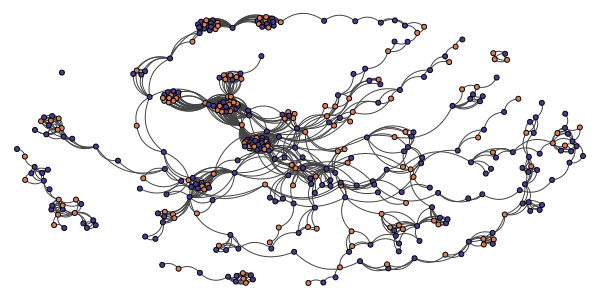

In [534]:
visual_style = {}

# Define colors used for gender visualization
colors = ['#4a3b90', '#d97d5b']
a.network.vs["color"] = [colors[0] if x == 'man' else colors[1] for x in a.network.vs['gender']]

# Set bbox and margin
visual_style["bbox"] = (600,300)
visual_style["margin"] = 17

# Set vertex size
visual_style["vertex_size"] = 5

# Set vertex lable size
visual_style["vertex_label_size"] = 8

# curve the edges
visual_style["edge_curved"] = True

# Plot the graph
igraph.plot(a.network, **visual_style)